# Add & install Important Libraries

In [2]:
!pip install transformers
!pip install datasets
!pip install --upgrade accelerate
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AdamW, get_scheduler
from datasets import Dataset, load_metric
import torch
import torch.nn as nn
from tqdm.notebook import tqdm_notebook
from torch.utils.data import DataLoader

# Import DataSet from Github

In [4]:
train_data = pd.read_csv('https://raw.githubusercontent.com/dml-qom/FarsTail/master/data/Train-word.csv' , sep='\t',  header=[0])
val_data = pd.read_csv('https://raw.githubusercontent.com/dml-qom/FarsTail/master/data/Val-word.csv' , sep='\t',  header=[0])
test_data = pd.read_csv('https://raw.githubusercontent.com/dml-qom/FarsTail/master/data/Test-word.csv' , sep='\t',  header=[0])

# EDA & Data PreProcessing

In [5]:
train_data.head()

,premise,hypothesis,label
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,e
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر، اندلس و شام، نخستین ر...,c
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,n
3,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,نقاشی های تزئینی و تندیس های بی‌کیفیت، یکی از ...,e
4,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,با کیفیت بودن تندیس های دوره اموی، یکی از ویژگ...,c


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7266 entries, 0 to 7265
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     7266 non-null   object
 1   hypothesis  7266 non-null   object
 2   label       7266 non-null   object
dtypes: object(3)
memory usage: 170.4+ KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   premise           1564 non-null   object
 1   hypothesis        1564 non-null   object
 2   label             1564 non-null   object
 3   hard(hypothesis)  1564 non-null   int64 
 4   hard(overlap)     1564 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 61.2+ KB


In [8]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     1537 non-null   object
 1   hypothesis  1537 non-null   object
 2   label       1537 non-null   object
dtypes: object(3)
memory usage: 36.1+ KB


In [9]:
np.unique(train_data['label'])

array(['c', 'e', 'n'], dtype=object)

<Axes: >

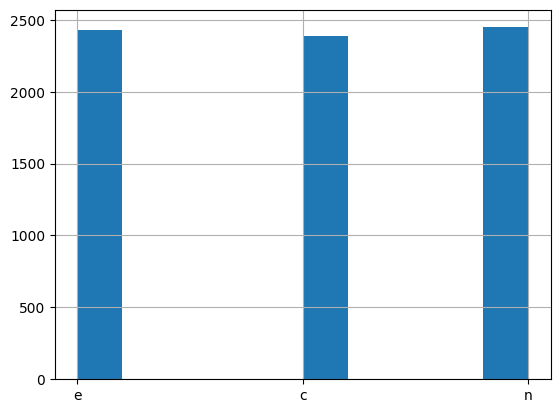

In [10]:
train_data['label'].hist()

In [11]:
# Turn Category in to class_numbers --------------------------------------------
train_data['label'] = train_data['label'].replace({'e':0,'c':1,'n':2})
val_data['label'] = val_data['label'].replace({'e':0,'c':1,'n':2})
test_data ['label'] = test_data ['label'].replace({'e':0,'c':1,'n':2})

In [12]:
train_data

,premise,hypothesis,label
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,0
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر، اندلس و شام، نخستین ر...,1
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,2
3,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,نقاشی های تزئینی و تندیس های بی‌کیفیت، یکی از ...,0
4,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,با کیفیت بودن تندیس های دوره اموی، یکی از ویژگ...,1
...,...,...,...
7261,قانون اساسی جمهوری اسلامی ایران در سال ۱۳۵۸ تو...,تعداد فصول قانون اساسی ۱۴ و تعداد اصول آن ۱۷۷ ...,0
7262,قانون اساسی جمهوری اسلامی ایران در سال ۱۳۵۸ تو...,قانون اساسی دارای ۲۵ فصل و ۱۷۵ اصل می باشد.,1
7263,قانون اساسی جمهوری اسلامی ایران در سال ۱۳۵۸ تو...,در ۲۴ آبان ۵۸ کار تدوین قانون اساسی به پایان ر...,2
7264,محاصره اقتصادی پیامبر (ص) و یارانش که در سال ه...,حضرت محمد (ص) و یارانش از ششمین سال بعثت تا هش...,1


In [13]:
test_data

,premise,hypothesis,label,hard(hypothesis),hard(overlap)
0,دوران امامت امام صادق علیه السلام، مصادف است ب...,امام سجاد (ع) در دورانی امامت کردند که همزمان ...,1,0,1
1,دوران امامت امام صادق علیه السلام، مصادف است ب...,دستگاه فاسد حکومتی با صرف هزینه های هنگفت، سعی...,2,1,0
2,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,دوران محنت اهل بیت پس از شهادت امام رضا(ع) آغا...,0,0,0
3,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,بعد از به شهادت رسیدن امام هادی(ع) دوران محنت ...,1,1,1
4,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,حضرت جواد(ع) در سال ۱۹۵ هجری در مدینه ولادت یافت.,2,1,0
...,...,...,...,...,...
1559,دریای خَزَر یا دریای مازَندَران یا (با رواج کم...,در حاشیه ی دریای خزر کشور آذربایجان وجود ندارد.,1,0,1
1560,دریای خَزَر یا دریای مازَندَران یا (با رواج کم...,جمهوری آذربایجان به ترکی آذربایجانی بزرگترین ک...,2,0,1
1561,اولین چاپ مطالب به زبان فارسی در روزنامه‌های ه...,اولین روزنامه فارسی در هند انتشار یافت.,0,1,0
1562,اولین چاپ مطالب به زبان فارسی در روزنامه‌های ه...,ایران نخستین روزنامه فارسی را چاپ کرد.,1,1,0


In [14]:
test_data.drop(['hard(hypothesis)', 'hard(overlap)'], axis=1 , inplace = True)

# **The First Approach**

# Using Pars BERT as a Embedding Layer for Feed Forward Neural Network

In [18]:
train_dataset = Dataset.from_pandas(train_data)
valid_dataset = Dataset.from_pandas(val_data)
test_dataset  = Dataset.from_pandas(test_data)

In [19]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

In [30]:
def preprocess_function(row):
    tokenized_batch = tokenizer(row["premise"], row["hypothesis"],  truncation=True, padding=True )
    return tokenized_batch

In [31]:
train_dataset = train_dataset.map(preprocess_function, batched=True)
valid_dataset = valid_dataset.map(preprocess_function, batched=True)
test_dataset  = test_dataset .map(preprocess_function, batched=True)

Map:   0%|          | 0/7266 [00:00<?, ? examples/s]

Map:   0%|          | 0/1537 [00:00<?, ? examples/s]

Map:   0%|          | 0/1564 [00:00<?, ? examples/s]

In [32]:
class ParsBERT_Model(nn.Module):
    def __init__(self, num_labels):
        super(ParsBERT_Model, self).__init__()
        self.num_labels = num_labels
        self.ParsBERT = ParsBERT = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                       config=AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                                                         output_attentions=True,
                                                                                         output_hidden_states=True))
        self.dropout = nn.Dropout(0.1)
        self.Fc = nn.Linear(768, num_labels )

    def forward(self, input_ids = None, attention_mask=None, labels = None ):
        outputs = self.ParsBERT(input_ids = input_ids, attention_mask = attention_mask  )
        last_hidden_state = outputs[0]
        outputs = self.dropout(last_hidden_state)
        out = self.Fc(outputs[:, 0, : ].view(-1, 768 ))

        return out

In [33]:
train_dataset.set_format('torch', columns=["input_ids", "attention_mask", "label"] )
test_dataset.set_format('torch', columns=["input_ids", "attention_mask", "label"] )
valid_dataset.set_format('torch', columns=["input_ids", "attention_mask", "label"] )

In [34]:
def collate_batch(batch):
  input_ids =[]
  labels = []
  for b in batch:
    input_ids.append(b["input_ids"])
    labels.append(b["label"])
  input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0.0)
  return {"input_ids":input_ids ,"label":torch.Tensor(labels)}

In [35]:
def validation( model , val_loader , loss_fn , device = "cuda"  ):
  val_loss = 0.0
  model.eval()
  reals = []
  preds_list = []
  for batch in val_loader:
    input_ids = batch["input_ids"].to(device)
    labels = batch["label"].to(device)
    with torch.no_grad():
      preds = model(input_ids = input_ids )
    loss = loss_fn(preds , labels.to(torch.long))
    val_loss += loss.item()
    reals += labels.cpu().numpy().tolist()
    preds_list += preds.argmax(axis=1).cpu().numpy().tolist()

  val_loss = val_loss / len(val_loader)
  accuracy = accuracy_score(reals, preds_list, normalize=True)
  print(classification_report(reals , preds_list ))
  return val_loss ,accuracy

In [36]:
def validation_loss_accuracy( model , val_loader , loss_fn , device = "cuda"  ):
  val_loss = 0.0
  model.eval()
  reals = []
  preds_list = []
  for batch in val_loader:
    input_ids = batch["input_ids"].to(device)
    labels = batch["label"].to(device)
    with torch.no_grad():
      preds = model(input_ids = input_ids )
    loss = loss_fn(preds , labels.to(torch.long))
    val_loss += loss.item()
    reals += labels.cpu().numpy().tolist()
    preds_list += preds.argmax(axis=1).cpu().numpy().tolist()

  val_loss = val_loss / len(val_loader)
  accuracy = accuracy_score(reals, preds_list, normalize=True)

  return val_loss ,accuracy

In [37]:
def train(model , optimizer , loss_fn , train_loader , valid_loader  , test_loader , epochs , device = "cuda"):

  model.to(device)
  for epoch in range(epochs):
    training_loss = 0.0
    model.train()
    t_labels = []
    t_preds = []
    for batch in tqdm_notebook(train_loader):
      for name, param in model.named_parameters():
       if param.requires_grad and 'bert' in name:
        param.requires_grad = False
      optimizer.zero_grad()
      input_ids = batch["input_ids"].to(device)
      labels = batch["label"].to(device)
      preds = model(input_ids = input_ids  )
      loss = loss_fn(preds , labels.to(torch.long))
      t_labels += labels.cpu().numpy().tolist()
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
      t_preds +=  preds.argmax(axis=1).cpu().numpy().tolist()
    training_loss = training_loss / len(train_loader)
    train_accuracy =  accuracy_score(t_labels, t_preds, normalize=True)
    print('Epoch: {} ,training loss: {:.2f} , train accuracy: {:.2f} '.format(epoch , training_loss ,train_accuracy))
    validation_loss , validation_accuracy = validation_loss_accuracy(model , valid_loader , loss_fn , device  )
    print('validation loss: {:.2f} , validation accuracy: {:.2f} '.format(validation_loss ,validation_accuracy))
  test_loss , test_accuracy = validation(model , test_loader , loss_fn , device  )
  print('test loss: {:.2f}  test accuracy: {:.2f}'.format( test_loss , test_accuracy))

In [40]:
epoch = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ParsBERT_Model(num_labels = 3)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, shuffle = True, batch_size = 32, collate_fn = collate_batch)
val_loader   = DataLoader(valid_dataset, shuffle = True, collate_fn = collate_batch)
test_loader  = DataLoader(test_dataset, shuffle = True, batch_size = 16, collate_fn = collate_batch)

train(model , optimizer , loss_fn , train_loader , val_loader  , test_loader , epoch , device )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/228 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 0 ,training loss: 0.81 , train accuracy: 0.61 
validation loss: 0.64 , validation accuracy: 0.72 


  0%|          | 0/228 [00:00<?, ?it/s]

Epoch: 1 ,training loss: 0.48 , train accuracy: 0.80 
validation loss: 0.52 , validation accuracy: 0.79 


  0%|          | 0/228 [00:00<?, ?it/s]

Epoch: 2 ,training loss: 0.30 , train accuracy: 0.88 
validation loss: 0.58 , validation accuracy: 0.77 
              precision    recall  f1-score   support

         0.0       0.86      0.75      0.80       519
         1.0       0.70      0.79      0.74       510
         2.0       0.88      0.88      0.88       535

    accuracy                           0.81      1564
   macro avg       0.81      0.81      0.81      1564
weighted avg       0.81      0.81      0.81      1564

test loss: 0.50  test accuracy: 0.81


# **The Second Approach**

# Fine-tuning Pars BERT model

In [20]:
config   = AutoConfig   .from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", truncation=True, padding=True)
model    = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
train_dataset = Dataset.from_pandas(train_data)
valid_dataset = Dataset.from_pandas(val_data)
test_dataset  = Dataset.from_pandas(test_data)

def preprocess_function(row):
    tokenized_batch = tokenizer(row["premise"], row["hypothesis"],  truncation=True, padding=True )
    return tokenized_batch

train_dataset = train_dataset.map(preprocess_function, batched=True)
valid_dataset = valid_dataset.map(preprocess_function, batched=True)
test_dataset  = test_dataset .map(preprocess_function, batched=True)

Map:   0%|          | 0/7266 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1537 [00:00<?, ? examples/s]

Map:   0%|          | 0/1564 [00:00<?, ? examples/s]

In [22]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = load_metric("accuracy")
    return metric.compute(predictions=predictions, references=labels)

In [27]:
training_args = TrainingArguments(
    output_dir                  = "./result_2",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    num_train_epochs            = 3,

    gradient_accumulation_steps = 1,
    overwrite_output_dir        = True,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",

)

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_dataset,
    eval_dataset    = valid_dataset,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.000556,0.806766
2,0.222900,0.718565,0.810020
3,0.187900,0.996578,0.813923


<ipython-input-22-77fad9845005>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


TrainOutput(global_step=1365, training_loss=0.17527049696925795, metrics={'train_runtime': 680.0935, 'train_samples_per_second': 32.051, 'train_steps_per_second': 2.007, 'total_flos': 1719985772916180.0, 'train_loss': 0.17527049696925795, 'epoch': 3.0})

In [28]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.9134799242019653,
 'eval_accuracy': 0.828005115089514,
 'eval_runtime': 14.2468,
 'eval_samples_per_second': 109.779,
 'eval_steps_per_second': 6.879,
 'epoch': 3.0}

In [29]:
pred = trainer.predict(test_dataset)
print( classification_report( pred.label_ids , pred.predictions.argmax(-1) , labels=[0, 1, 2]) )

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       519
           1       0.76      0.75      0.76       510
           2       0.89      0.89      0.89       535

    accuracy                           0.83      1564
   macro avg       0.83      0.83      0.83      1564
weighted avg       0.83      0.83      0.83      1564

